<a href="https://colab.research.google.com/github/cevhersoylemez/Adult-Data-Analysis-for-Classification/blob/master/Duygu_Tan%C4%B1ma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate



KeyboardInterrupt



In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
import sys
sys.path.insert(0, 'drive/Colab Notebooks')

Gerekli Paketlerin Yüklenmesi

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

Veri setinin okunması

In [0]:
data = pd.read_csv("drive/Colab Notebooks/fer2013.csv")
data.shape 

(35887, 3)

Veriden bir kısım görelim.

In [0]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Eğitim ve test performansının ölçüldüğü veri sayılarını inceleyelim.

In [0]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### EĞİTİM VERİSİ İÇİN ÖN İŞLEME ADIMLARI

In [0]:
np.unique(data["Usage"].values.ravel())

print('Eğitim verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

Eğitim verisetindeki örnek sayısı: 28709


Eğitim işlemi için veri kümesinde ayrılmış olan Training kısmını alıyoruz.

In [0]:
train_data = data[data.Usage == "Training"] #sadece eğitim örneklerini train_data değişkenine aldık

In [0]:
#eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [0]:
#Görüntüyü 48x48 piksel şeklinde göstermek için bir fonksiyon tanımlayalım
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

Eğitim kümesinden bir örnek görsel

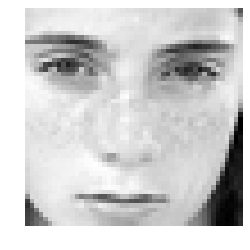

In [0]:
#Veri kümesinden 
show(train_images[28708])

Eğitim kümesinde kaç sınıf bulunuyor bunu görelim.



In [0]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


One Hot ile eğitim kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.

In [0]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [0]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


### TEST VERİSİ ÖN İŞLEME ADIMLARI

In [0]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


Eğitim işlemi için veri kümesinde ayrılmış olan PublicTest kısmını alıyoruz.

In [0]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

#test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

(3589, 2304)


**Test kümesinden bir örnek görsel**

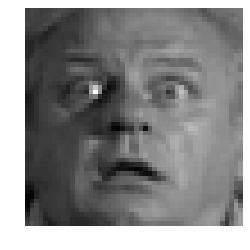

In [0]:
#bir test örneği gösterelim
show(test_images[1000])

One Hot ile test kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.

In [0]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)
y_test = y_test.astype(np.uint8)


print(y_test.shape)

(3589, 7)


### TEST KÜMESİNDEN ÖRNEK GÖRÜNTÜLER

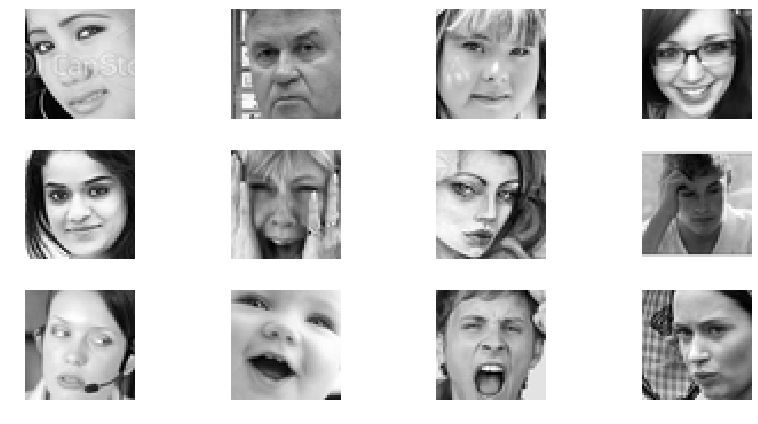

In [0]:
#test verisetinden örneklerden bir kaçını toplu halde görelim

plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.axis('off')
    
    image = test_images[i].reshape(48,48)
    plt.imshow(image, cmap="gray")

plt.tight_layout()
plt.show()

### **DERİN EVRİŞİMLİ SİNİR AĞI MODELİ TANIMLANMASI**

In [0]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

#3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

#TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

#Çıkış katmanı
model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
model.summary() #model özetini görselleştirelim

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
__________

Eğtim ve Test kümelerinin eleman sayısı, yükseklik ve genişlik, kanalsayısı bilgilerini ekrana yazdıralım.

In [0]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print("Train:", x_train.shape)
print("Test:", x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


Eğitim ve Test kümelerinin eleman ve duygu sınıf sayısı.

In [0]:
print("Train:", y_train.shape)
print("Test:", y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin belirlenmesi ve eğitim sonucunda ağırlıkların .h5 dosyası olarak kaydedilmesi işlemleri

In [0]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath='drive/Colab Notebooks/face_model.h5', verbose=1, save_best_only=True)

epochs = 10
batchSize = 100 

# modeli çalıştır
hist = model.fit(x_train, y_train, 
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize, 
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("drive/Colab Notebooks/face_model.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
 - 1040s - loss: 2.0010 - acc: 0.2548 - val_loss: 1.6234 - val_acc: 0.3656

Epoch 00001: val_loss improved from inf to 1.62344, saving model to drive/Colab Notebooks/face_model.h5
Epoch 2/10
 - 1046s - loss: 1.6595 - acc: 0.3484 - val_loss: 1.5147 - val_acc: 0.4241

Epoch 00002: val_loss improved from 1.62344 to 1.51475, saving model to drive/Colab Notebooks/face_model.h5
Epoch 3/10
 - 1031s - loss: 1.5559 - acc: 0.3928 - val_loss: 1.4255 - val_acc: 0.4503

Epoch 00003: val_loss improved from 1.51475 to 1.42549, saving model to drive/Colab Notebooks/face_model.h5
Epoch 4/10
 - 1005s - loss: 1.4872 - acc: 0.4245 - val_loss: 1.3638 - val_acc: 0.4776

Epoch 00004: val_loss improved from 1.42549 to 1.36377, saving model to drive/Colab Notebooks/face_model.h5
Epoch 5/10
 - 1026s - loss: 1.4336 - acc: 0.4473 - val_loss: 1.3756 - val_acc: 0.4511

Epoch 00005: val_loss did not improve from 1.36377
Epoch 6/10
 - 1009s - loss: 1.3816 - 

**Eğitim sonucu elde edilen Eğitim ve Geçerleme (Validation) sonuçlarının grafiksel olarak ifade edilip ekrarna yazdırılması işlemleri.**

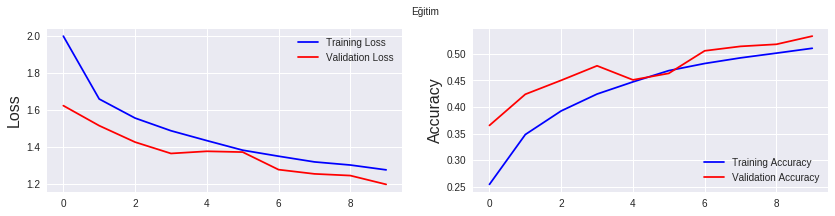

In [0]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### **Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirelim.**

In [0]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image


Daha önceki eğitimde kaydettiğimiz modelin hesapladığını öğrenilmiş ağırlık dosyasını kullanıyoruz.

In [0]:
# en iyi ağırlıkları yükle
model_best = load_model('drive/Colab Notebooks/face_model.h5')

**Test görüntüsünü okuma ve yeniden boytlandırma işlemleri ve Kestirim sonucunun hesaplanması ve ekrana yazdırılması**

In [94]:
#test_image=x_test_private[60] #eğer veri kümesinden bir görsel denemek isterseniz burada [] içine rastgele bir görsel numarası atayarak test edebilirsiniz!

image_path = "drive/Colab Notebooks/input_imgs/bihter.jpg"

test_image_orjinal = image.load_img(image_path) # orjinal renkli görüntü


test_image = image.load_img(image_path, target_size=(48,48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1) 
results

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[0.20345646, 0.00368503, 0.13072538, 0.05353857, 0.33154914,
        0.03369085, 0.2433546 ]], dtype=float32)

### SONUÇLARIN GÖRSELLEŞTİRİLMESİ ADIMLARI

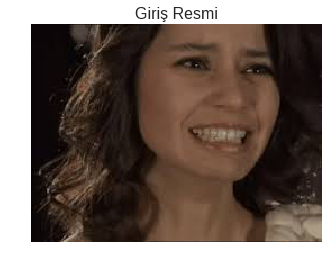

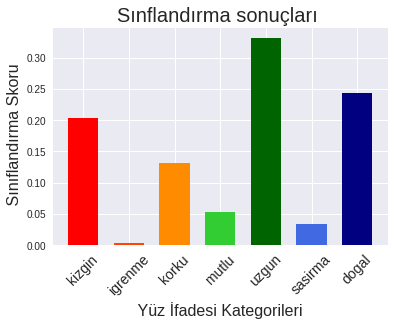

Sınıflandırma sonucu en yüksek oranla: uzgun


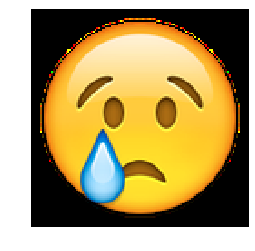

In [95]:
#sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))  #
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']


# test resmimizi çizdirelim
plt.imshow(test_image_orjinal)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()


#sonuçlarımızı renklendirelim
for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])
  
plt.title("Sınflandırma sonuçları ",fontsize=20)
plt.xlabel(" Yüz İfadesi Kategorileri ",fontsize=16)
plt.ylabel(" Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])


# en yüksek skorlu duyguya karşılık emoji çizdirelim
emojis_img = image.load_img('drive/Colab Notebooks/emojis/%s.png' % str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()